In [61]:
import struct
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as pyo
import math
import os

In [87]:
def add_flight_states_and_events(fig, flight_states_df, event_info_df):
    for _, state in flight_states_df.iterrows():
        fig.add_vline(x=state['ts'], line_width=1, line_dash="dash", line_color="green", annotation_text=state['state'])
#         fig.add_trace(
#         go.Scatter(
#             x=[5, 5, 6, 6], 
#             y=[-100,  100, 100, -100], 
#             fill="toself",
#             mode='lines',
#             text= state['state'],
#             name = state['state'],
#             opacity=0
#         )
#     )
    for _, event in event_info_df.iterrows():
        if event['out_idx'] == 0:
            fig.add_vline(x=event['ts'], line_width=1, line_dash="dot", line_color="orange",
                          annotation_text=event['event'], annotation_y=0.03)


def plot_imu_data(imu_df, flight_states_df, event_info_df, ret=False):
    fig_ax = go.Figure()
    fig_ay = go.Figure()
    fig_az = go.Figure()
    fig_gx = go.Figure()
    fig_gy = go.Figure()
    fig_gz = go.Figure()
    for imu_id, one_imu in imu_df.groupby('id'):
        fig_ax.add_scatter(x=one_imu.ts, y=one_imu.Ax, name=imu_id, mode='lines')
        fig_ay.add_scatter(x=one_imu.ts, y=one_imu.Ay, name=imu_id, mode='lines')
        fig_az.add_scatter(x=one_imu.ts, y=one_imu.Az, name=imu_id, mode='lines')
        fig_gx.add_scatter(x=one_imu.ts, y=one_imu.Gx, name=imu_id, mode='lines')
        fig_gy.add_scatter(x=one_imu.ts, y=one_imu.Gy, name=imu_id, mode='lines')
        fig_gz.add_scatter(x=one_imu.ts, y=one_imu.Gz, name=imu_id, mode='lines')

    add_flight_states_and_events(fig_ax, flight_states_df, event_info_df)
    add_flight_states_and_events(fig_ay, flight_states_df, event_info_df)
    add_flight_states_and_events(fig_az, flight_states_df, event_info_df)
    add_flight_states_and_events(fig_gx, flight_states_df, event_info_df)
    add_flight_states_and_events(fig_gy, flight_states_df, event_info_df)
    add_flight_states_and_events(fig_gz, flight_states_df, event_info_df)

    fig_ax.update_layout(
        title="IMU Acc_x",
        yaxis_title="Acc_x [g]",
        legend_title="IMU ID",
        **layout_args
    )

    fig_ay.update_layout(
        title="IMU Acc_y",
        yaxis_title="Acc_y [g]",
        legend_title="IMU ID",
        **layout_args
    )

    fig_az.update_layout(
        title="IMU Acc_z",
        yaxis_title="Acc_z [g]",
        legend_title="IMU ID",
        **layout_args
    )

    fig_gx.update_layout(
        title="IMU Gyro_x",
        yaxis_title="Gyro_x [dps]",
        legend_title="IMU ID",
        **layout_args
    )

    fig_gy.update_layout(
        title="IMU Gyro_y",
        yaxis_title="Gyro_y [dps]",
        legend_title="IMU ID",
        **layout_args
    )

    fig_gz.update_layout(
        title="IMU Gyro_z",
        yaxis_title="Gyro_z [dps]",
        legend_title="IMU ID",
        **layout_args
    )

    if ret:
        return [fig_ax, fig_ay, fig_az, fig_gx, fig_gy, fig_gz]
    else:
        fig_ax.show()
        fig_ay.show()
        fig_az.show()
        fig_gx.show()
        fig_gy.show()
        fig_gz.show()
        return None


def plot_baro_data(baro_df, flight_states_df, event_info_df, ret=False):
    fig_temp = go.Figure()
    fig_press = go.Figure()
    for baro_id, one_baro in baro_df.groupby('id'):
        fig_temp.add_scatter(x=one_baro.ts, y=one_baro['T'], name=baro_id, mode='lines')
        fig_press.add_scatter(x=one_baro.ts, y=one_baro['P'], name=baro_id, mode='lines')

    add_flight_states_and_events(fig_temp, flight_states_df, event_info_df)
    add_flight_states_and_events(fig_press, flight_states_df, event_info_df)

    deg = u'\N{DEGREE SIGN}'
    fig_temp.update_layout(
        title="BARO Temperature",
        yaxis_title=f"T [{deg}C]",
        legend_title="BARO ID",
        **layout_args
    )

    fig_press.update_layout(
        title="BARO Pressure",
        yaxis_title="P [hPa]",
        legend_title="BARO ID",
        **layout_args
    )

    if ret:
        return [fig_temp, fig_press]
    else:
        fig_temp.show()
        fig_press.show()
        return None


def plot_flight_info(flight_info_df, filtered_data_info_df, flight_states_df, event_info_df, include_bounds = True, ret=False):
    fig_height = go.Figure()
    fig_vel = go.Figure()
    fig_acc = go.Figure()

    fig_height.add_scatter(x=flight_info_df.ts, y=flight_info_df['height'], name="height", mode='lines')
    fig_height.add_scatter(x=flight_info_df.ts, y=flight_info_df['altitude_agl'], name="altitude_agl", mode='lines')
    fig_height.add_scatter(x=filtered_data_info_df.ts, y=filtered_data_info_df['filtered_altitude_AGL'], name='filtered_altitude_agl', mode='lines')
        
    if include_bounds:
        fig_height.add_scatter(x=flight_info_df.ts, y=flight_info_df['lower_bound'], name="lower_bound", mode='lines')
        fig_height.add_scatter(x=flight_info_df.ts, y=flight_info_df['upper_bound'], name="upper_bound", mode='lines')

    fig_vel.add_scatter(x=flight_info_df.ts, y=flight_info_df['velocity'], name="velocity", mode='lines')

    fig_acc.add_scatter(x=flight_info_df.ts, y=flight_info_df['acceleration'], name="acceleration", mode='lines')
    fig_acc.add_scatter(x=filtered_data_info_df.ts, y=filtered_data_info_df['filtered_acceleration'], name="filtered_acceleration", mode='lines')

    add_flight_states_and_events(fig_height, flight_states_df, event_info_df)
    add_flight_states_and_events(fig_vel, flight_states_df, event_info_df)
    add_flight_states_and_events(fig_acc, flight_states_df, event_info_df)

    fig_height.update_layout(
        title="Height",
        yaxis_title="Height [m]",
        **layout_args
    )

    fig_vel.update_layout(
        title="Velocity",
        yaxis_title="Velocity [m/s]",
        **layout_args
    )

    squared = u'\N{SUPERSCRIPT TWO}'
    fig_acc.update_layout(
        title="Acceleration",
        yaxis_title=f"Acceleration [m/s{squared}]",
        **layout_args
    )
    if ret:
        return [fig_height, fig_vel, fig_acc]
    else:
        fig_height.show()
        fig_vel.show()
        fig_acc.show()
        return None


def figures_to_html(imu_plots, baro_plots, state_plots, filename):
    '''Saves a list of plotly figures in an html file.'''

    dashboard = open(filename, 'w')
    head = """<html><head>
    <style>
        body {background-color: black;}
        div  {display: inline-block;margin: 2px; padding:2px;}
        h1 {font-size: 3em; color: floralwhite; font-family: 'Courier New', monospace}
        h2 {font-size: 2em; color: floralwhite; font-family: 'Courier New', monospace; margin-bottom: 2px}
        .container { white-space: nowrap; }
    </style>
    </head><body><center>\n"""
    dashboard.write(head)

    #         span {
    #             float: left;
    #             white-space:nowrap;
    #         }

    dashboard.write('<h1>IMU Data - Acceleration</h1>')
    #dashboard.write('<h1>IMU Data - Acceleration</h1><div class="container">')

    add_js = True
    xyz = 'XYZ'
    i = 0
    for fig in imu_plots[:3]:
        inner_html = pyo.plot(
            fig, include_plotlyjs=add_js, output_type='div'
        )
        dashboard.write(f'<h2>Acc {xyz[i]}</h2><div class="container">')
        dashboard.write(inner_html)
        dashboard.write('</div>')
        add_js = False
        i += 1

    dashboard.write('<br/>')

    i = 0
    dashboard.write('<h1>IMU Data - Gyros</h1>')
    for fig in imu_plots[3:]:
        inner_html = pyo.plot(
            fig, include_plotlyjs=add_js, output_type='div'
        )
        dashboard.write(f'<h2>Gyro {xyz[i]}</h2><div class="container">')
        dashboard.write(inner_html)
        dashboard.write('</div>')
        add_js = False
        i += 1

    dashboard.write('<br/>')

    dashboard.write('<h1>Barometer Data</h1>')
    xyz = ['Temperature', 'Pressure']
    i = 0
    for fig in baro_plots:
        inner_html = pyo.plot(
            fig, include_plotlyjs=add_js, output_type='div'
        )
        dashboard.write(f'<h2>{xyz[i]}</h2><div class="container">')
        dashboard.write(inner_html)
        dashboard.write('</div>')
        add_js = False
        i += 1

    dashboard.write('<br/>')

    dashboard.write('<h1>State Estimation Data</h1>')

    xyz = ['AGL Altitude & Height', 'Velocity', 'Acceleration']
    i = 0
    for fig in state_plots:
        inner_html = pyo.plot(
            fig, include_plotlyjs=add_js, output_type='div'
        )
        dashboard.write(f'<h2>{xyz[i]}</h2><div class="container">')
        dashboard.write(inner_html)
        dashboard.write('</div>')
        add_js = False
        i += 1

    dashboard.write('<br/>')

    dashboard.write("</center></body></html>" + "\n")

In [88]:
FLIGHT_MAP = {
    0: 'INVALID',
    1: 'MOVING',
    2: 'IDLE',
    3: 'THRUSTING_1',
    4: 'THRUSTING_2',
    5: 'COASTING',
    6: 'TRANSONIC_1',
    7: 'SUPERSONIC',
    8: 'TRANSONIC_2',
    9: 'APOGEE',
    10: 'DROGUE',
    11: 'MAIN',
    12: 'TOUCHDOWN',
    0x7FFFFFFF: 'HEHE2'
}

DROP_MAP = {
    0: 'INVALID',
    1: 'MOVING',
    2: 'IDLE',
    3: 'DROGUE CHUTE',
    4: 'MAIN CHUTE',
    0x7FFFFFFF: 'HEHE'
}

EVENT_MAP = {
    1: 'EV_IDLE',
    2: 'EV_MOVING',
    3: 'EV_LIFTOFF',
    4: 'EV_MAX_V',
    5: 'EV_APOGEE',
    6: 'EV_POST_APOGEE',
    7: 'EV_TOUCHDOWN',
    8: 'EV_TIMER_1',
    9: 'EV_TIMER_2',
    0xFFFFFFFF: 'EV_HEHE'
}

ERROR_MAP = {
0x01 : 'ERR_NO_CONFIG',
0x02 : 'ERR_NO_PYRO',
0x04 : 'ERR_LOG_FULL',
0x08 : 'ERR_USB_CONNECTED',
0x10 : 'ERR_BAT_LOW',
0x20 : 'ERR_BAT_CRITICAL',
0x40 : 'ERR_IMU',
0x80 : 'ERR_BARO',
0x100 : 'ERR_FILTER',
0x200 : 'ERR_HARD_FAULT',
    0xFFFFFFFF: 'ERR_HEHE'
}

layout_font = dict(family="Courier New, monospace", size=12)

legend = dict(orientation='h', yanchor="bottom", y=1.02, xanchor="right", x=1)

layout_args = dict(xaxis_title="Timestamp [s]",
                   template='plotly_dark',
                   legend=legend,
                   font=layout_font,
                   width=1500, height=800)

In [89]:
log = 'flight_logs/testing_folder/teraterm.txt'
STATE_MAP = FLIGHT_MAP

base_name = log.split('/')[-1].split('.')[0]

plot_output_dir = f'output/{base_name}'
raw_output_dir = f'output/{base_name}/raw'
processed_output_dir = f'output/{base_name}/processed'

for out_dir in [plot_output_dir, raw_output_dir, processed_output_dir]:
    if not os.path.exists(out_dir):
            os.makedirs(out_dir)

In [90]:
with open(log, 'r') as f:
    log_str = f.read()

log_str_formatted = log_str.replace('\r\n', ' ')
log_str_formatted = log_str_formatted.replace('\n', ' ')
log_str_formatted = log_str_formatted.replace('  ', ' ')
log_str_formatted = log_str_formatted.strip()

In [91]:
log_b = bytes.fromhex(log_str_formatted)[4936:]

print(log_b[:20])

b"\x80\x00\x00\x00\x0f.\x00\x00\x00@'<w\x9e\xda>\x00\x04\x00\x00"


In [92]:
imu = []
baro = []
flight_info = []
filtered_data_info = []
flight_states = []
covariance_info = []
sensor_info = []
event_info = []
error_info = []
i = 0
first_ts = -1
last_ts = -1
try:
    while i < len(log_b):
        t = struct.unpack('<L', log_b[i:i + 4])[0]
        i += 4
        if t in [1, 2, 4]:
            ts, gyro_x, gyro_y, gyro_z, acc_x, acc_y, acc_z = struct.unpack('<Lhhhhhh', log_b[i: i + 16])
            if first_ts == -1:
                first_ts = ts
            #print(f"{ts} IMU {t-1}: Gx: {gyro_x}, Gy: {gyro_y}, Gz: {gyro_z}, Ax: {acc_x}, Ay: {acc_y}, Az: {acc_z}")
            imu.append({'ts': ts,
                        'id': f'IMU{int(math.log2(t)) - int(math.log2(1))}',
                        'Gx': gyro_x,
                        'Gy': gyro_y,
                        'Gz': gyro_z,
                        'Ax': acc_x,
                        'Ay': acc_y,
                        'Az': acc_z})
            #print(imu_data)
            i += 4 + 6 + 6  #ts + 6 x int16
        elif t in [8, 16, 32]:
            ts, pressure, temperature = struct.unpack('<LLL', log_b[i: i + 12])
            if first_ts == -1:
                first_ts = ts
            #print(f"{ts} BARO {t-4}: P: {pressure}, T: {temperature}")
            baro.append({'ts': ts,
                         'id': f'BARO{int(math.log2(t)) - int(math.log2(8))}',
                         'T': temperature,
                         'P': pressure})
            #print(baro_data)
            i += 4 + 4 + 4
        elif t == 64:
            ts, height, velocity, acceleration, altitude_agl = struct.unpack('<Lffff', log_b[i: i + 20])
            if first_ts == -1:
                first_ts = ts
            #print(f"{ts} FLIGHT_INFO: Height: {height}, Velocity: {velocity}, Acc: {acceleration}")
            flight_info.append({'ts': ts,
                                'height': height,
                                'velocity': velocity,
                                'acceleration': acceleration,
                                'altitude_agl': altitude_agl})
            #print(flight_info_data)
            i += 4 + 4 + 4 + 4 + 4
        elif t == 128:
            ts, filtered_acceleration, filtered_altitude_AGL = struct.unpack('<Lff', log_b[i: i + 12])
            if first_ts == -1:
                first_ts = ts
            #print(f"{ts} FLIGHT_INFO: Height: {height}, Velocity: {velocity}, Acc: {acceleration}")
            filtered_data_info.append({'ts': ts,
                                'filtered_acceleration': filtered_acceleration,
                                'filtered_altitude_AGL': filtered_altitude_AGL})
            #print(flight_info_data)
            i += 4 + 4 + 4   
        elif t == 256:
            #print("FLIGHT_STATE")
            ts, state = struct.unpack('<LL', log_b[i: i + 8])
            if first_ts == -1:
                first_ts = ts
            flight_states.append({'ts': ts, 'state': state})
            #print(f"{ts} FLIGHT STATE: State: {state}")
            i += 4 + 4
        elif t == 512:
            ts, height_cov, velocity_cov = struct.unpack('<Lff', log_b[i: i + 12])
            if first_ts == -1:
                first_ts = ts
            #print(f"{ts} COVARIANCE_INFO: Height cov: {height_cov}, Velocity cov: {velocity_cov}")
            covariance_info.append({'ts': ts,
                                    'height_cov': height_cov,
                                    'velocity_cov': velocity_cov})
            #print(flight_info_data)
            i += 4 + 4 + 4
        elif t == 1024:
            #print(f"Sensor info found at {i}")
            ts, imu_0, imu_1, imu_2, baro_0, baro_1, baro_2 = struct.unpack('<LBBBBBB', log_b[i: i + 10])
            if first_ts == -1:
                first_ts = ts
            sensor_info.append({'ts': ts,
                                'imu_0': imu_0,
                                'imu_1': imu_1,
                                'imu_2': imu_2,
                                'baro_0': baro_0, 'baro_1': baro_1, 'baro_2': baro_2})
            i += 4 + 6 + 2  # +2 is because of the padding
        elif t == 2048:
            #print(f"Event info found at {i}")
            ts, event, out_idx = struct.unpack('<LLB', log_b[i: i + 9])
            if first_ts == -1:
                first_ts = ts
            event_info.append({'ts': ts,
                               'event': event,
                               'out_idx': out_idx})
            i += 4 + 4 + 1 + 3  # +3 is because of the padding
        elif t == 4096:
            #print(f"Error info found at {i}")
            ts, error = struct.unpack('<LL', log_b[i: i + 8])
            if first_ts == -1:
                first_ts = ts
            error_info.append({'ts': ts,
                               'error': error})
            i += 4 + 4
        else:
            print(t)
            print(f"ERROR at {i}")
            break
        last_ts = ts
except Exception as e:
    print(f'Parsing ended with error: {e}')
finally:
    print(f'Parsing ended at position: {i}/{len(log_b)}\nFirst timestamp: {first_ts / 1000}s; Last timestamp: {last_ts / 1000}s\n')

4294967295
ERROR at 389572
Parsing ended at position: 389572/392376
First timestamp: 11.791s; Last timestamp: 33.431s



In [93]:
ev_liftoff_ts = 0
for event in event_info:
    event['event'] = EVENT_MAP[event['event']]
    print(f"{event['ts']} -- {event['event']} -- out_idx: {event['out_idx']}")
    if event['event'] == 'EV_LIFTOFF':
        ev_liftoff_ts = event['ts']

In [94]:
for state in flight_states:
    state['state'] = STATE_MAP[state['state']]
    print(f"{state['ts']} -- {state['state']}")

In [95]:
for error in error_info:
    error['error'] = ERROR_MAP[error['error']]
    print(f"{error['ts']} -- {error['error']}")

In [96]:
imu_df = pd.DataFrame(imu)
baro_df = pd.DataFrame(baro)
flight_info_df = pd.DataFrame(flight_info)
filtered_data_info_df = pd.DataFrame(filtered_data_info)
covariance_df = pd.DataFrame(covariance_info)
flight_info_df['lower_bound'] = flight_info_df['height'] + 3 * (covariance_df['height_cov']) ** 0.5
flight_info_df['upper_bound'] = flight_info_df['height'] - 3 * (covariance_df['height_cov']) ** 0.5
sensor_info_df = pd.DataFrame(sensor_info)
event_info_df = pd.DataFrame(event_info)
error_info_df = pd.DataFrame(error_info)
flight_states_df = pd.DataFrame(flight_states)

## Save Raw Logs

In [97]:
imu_df.to_csv(f'{raw_output_dir}/{base_name} - imu_raw.csv')
baro_df.to_csv(f'{raw_output_dir}/{base_name} - baro_raw.csv')
flight_info_df.to_csv(f'{raw_output_dir}/{base_name} - flight_info_raw.csv')
filtered_data_info_df.to_csv(f'{raw_output_dir}/{base_name} - filtered_data_info_raw.csv')
covariance_df.to_csv(f'{raw_output_dir}/{base_name} - covariance_df_raw.csv')
sensor_info_df.to_csv(f'{raw_output_dir}/{base_name} - sensor_info_raw.csv')
event_info_df.to_csv(f'{raw_output_dir}/{base_name} - event_info_raw.csv')
error_info_df.to_csv(f'{raw_output_dir}/{base_name} - error_info_raw.csv')
flight_states_df.to_csv(f'{raw_output_dir}/{base_name} - flight_states_raw.csv')

## Process Logs

In [98]:
def offset_col(df, col, offset):
    df[col] -= offset


def scale_col(df, col, scale_factor):
    df[col] /= scale_factor

zero_ts = first_ts
if ev_liftoff_ts > 0:
    zero_ts = ev_liftoff_ts
    
offset_col(imu_df, 'ts', zero_ts)
offset_col(baro_df, 'ts', zero_ts)
offset_col(flight_info_df, 'ts', zero_ts)
offset_col(filtered_data_info_df, 'ts', zero_ts)
offset_col(covariance_df, 'ts', zero_ts)
offset_col(sensor_info_df, 'ts', zero_ts)

scale_col(imu_df, 'ts', 1000)
scale_col(baro_df, 'ts', 1000)
scale_col(flight_info_df, 'ts', 1000)
scale_col(filtered_data_info_df, 'ts', 1000)
scale_col(covariance_df, 'ts', 1000)
scale_col(sensor_info_df, 'ts', 1000)

if len(event_info_df) > 0:
    offset_col(event_info_df, 'ts', zero_ts)
    scale_col(event_info_df, 'ts', 1000)
if len(flight_states_df) > 0:
    offset_col(flight_states_df, 'ts', zero_ts)
    scale_col(flight_states_df, 'ts', 1000)
if len(error_info_df) > 0:
    offset_col(error_info_df, 'ts', zero_ts)
    scale_col(error_info_df, 'ts', 1000)

scale_col(imu_df, 'Gx', 16.4)
scale_col(imu_df, 'Gy', 16.4)
scale_col(imu_df, 'Gz', 16.4)
scale_col(imu_df, 'Ax', 1024)
scale_col(imu_df, 'Ay', 1024)
scale_col(imu_df, 'Az', 1024)

scale_col(baro_df, 'T', 100)

## Save Processed Logs

In [99]:
imu_df.to_csv(f'{processed_output_dir}/{base_name} - imu_processed.csv')
baro_df.to_csv(f'{processed_output_dir}/{base_name} - baro_processed.csv')
flight_info_df.to_csv(f'{processed_output_dir}/{base_name} - flight_info_processed.csv')
filtered_data_info_df.to_csv(f'{processed_output_dir}/{base_name} - filtered_data_info_processed.csv')
covariance_df.to_csv(f'{processed_output_dir}/{base_name} - covariance_df_processed.csv')
sensor_info_df.to_csv(f'{processed_output_dir}/{base_name} - sensor_info_processed.csv')
event_info_df.to_csv(f'{processed_output_dir}/{base_name} - event_info_processed.csv')
error_info_df.to_csv(f'{processed_output_dir}/{base_name} - error_info_processed.csv')
flight_states_df.to_csv(f'{processed_output_dir}/{base_name} - flight_states_processed.csv')

## Generate Plots

In [100]:
def add_flight_states_and_events(fig, flight_states_df, event_info_df):
    for _, state in flight_states_df.iterrows():
        fig.add_vline(x=state['ts'], line_width=1, line_dash="dash", line_color="green", annotation_text=state['state'])

    for _, event in event_info_df.iterrows():
        if event['out_idx'] == 0:
            fig.add_vline(x=event['ts'], line_width=1, line_dash="dot", line_color="orange",
                          annotation_text=event['event'], annotation_y=0.03)
            
    for _, error in error_info_df.iterrows():
        fig.add_vline(x=error['ts'], line_width=1, line_dash="dot", line_color="red",
                      annotation_text=error['error'], annotation_y=0.03)    

In [102]:
imu_plots = plot_imu_data(imu_df, flight_states_df, event_info_df, True)
baro_plots = plot_baro_data(baro_df, flight_states_df, event_info_df, True)
state_plots = plot_flight_info(flight_info_df, filtered_data_info_df, flight_states_df, event_info_df, False, True)

In [103]:
out_name = log.split('/')[-1].split('.')[0]
figures_to_html(imu_plots, baro_plots, state_plots, f'{plot_output_dir}/{base_name} - plots.html')

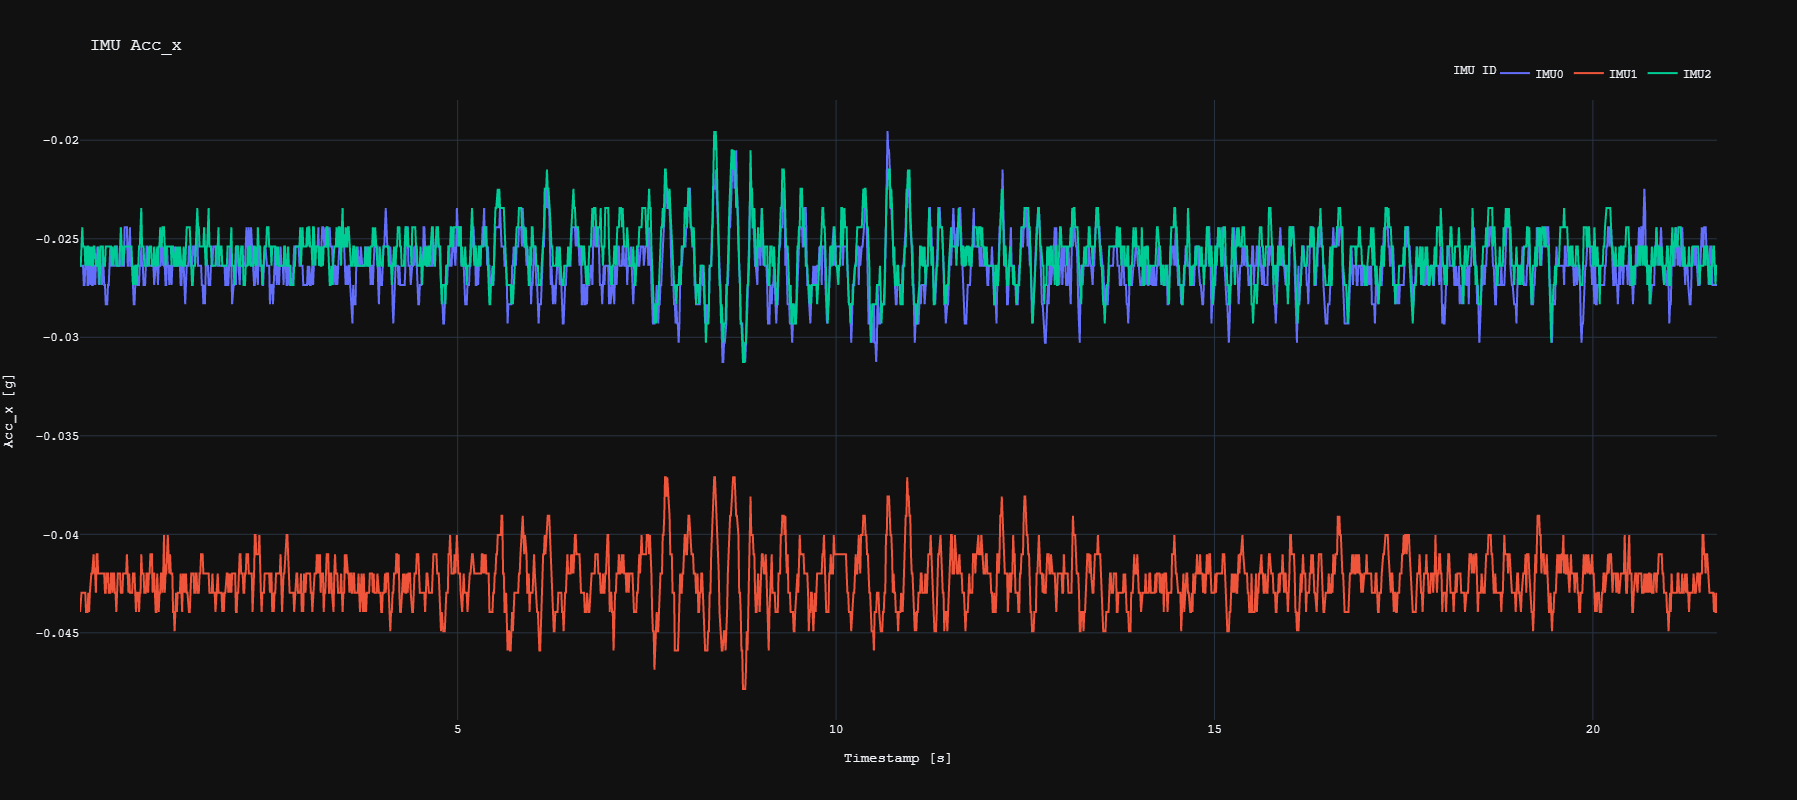

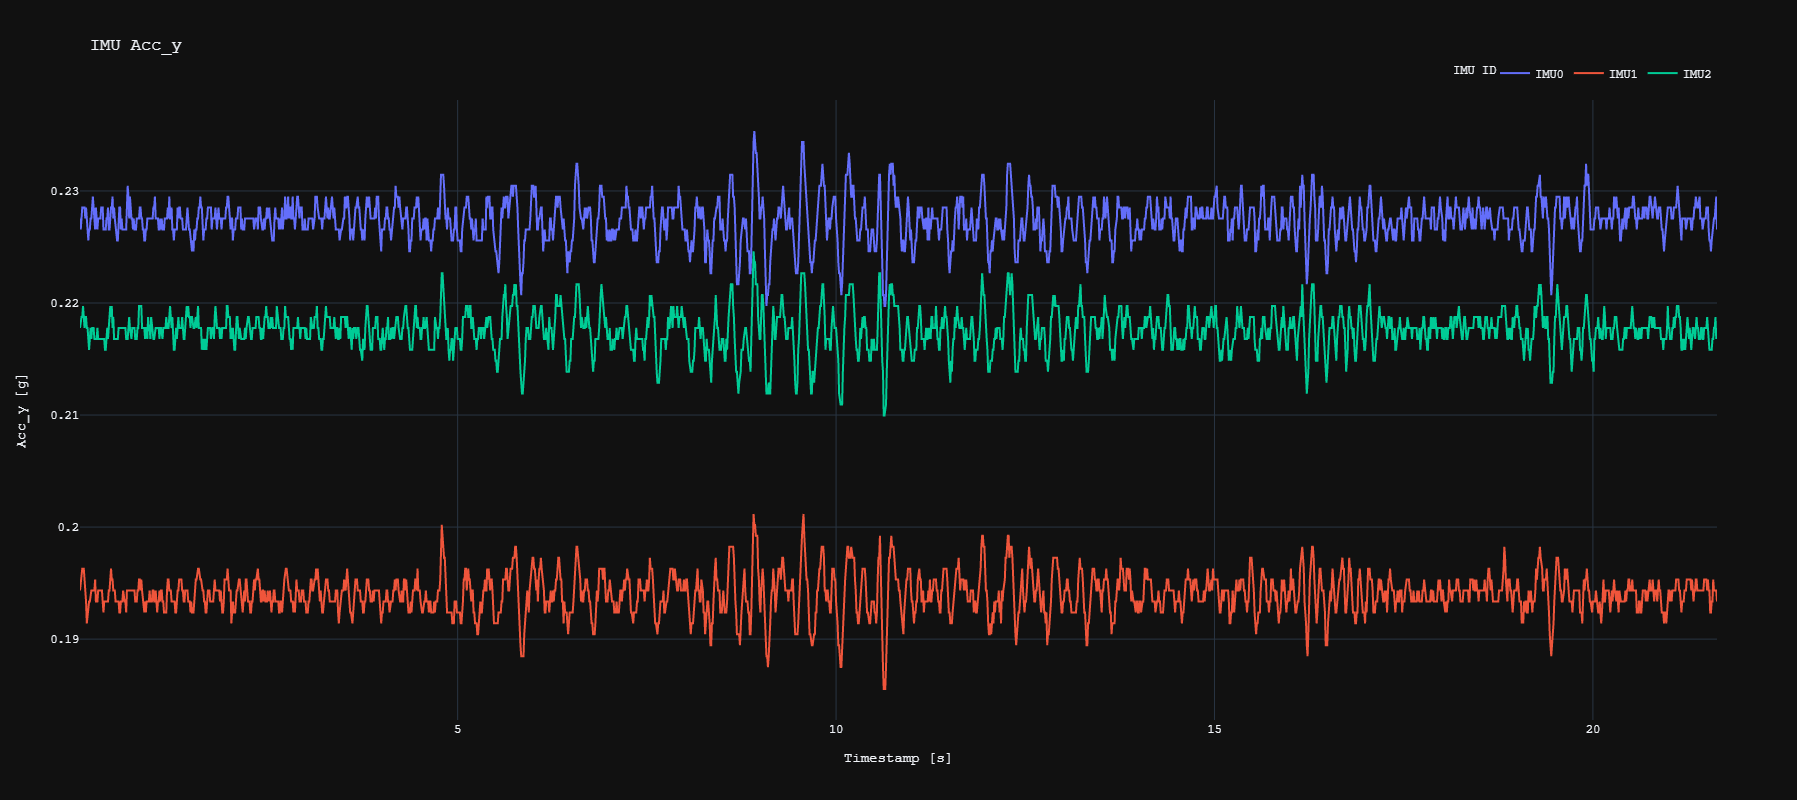

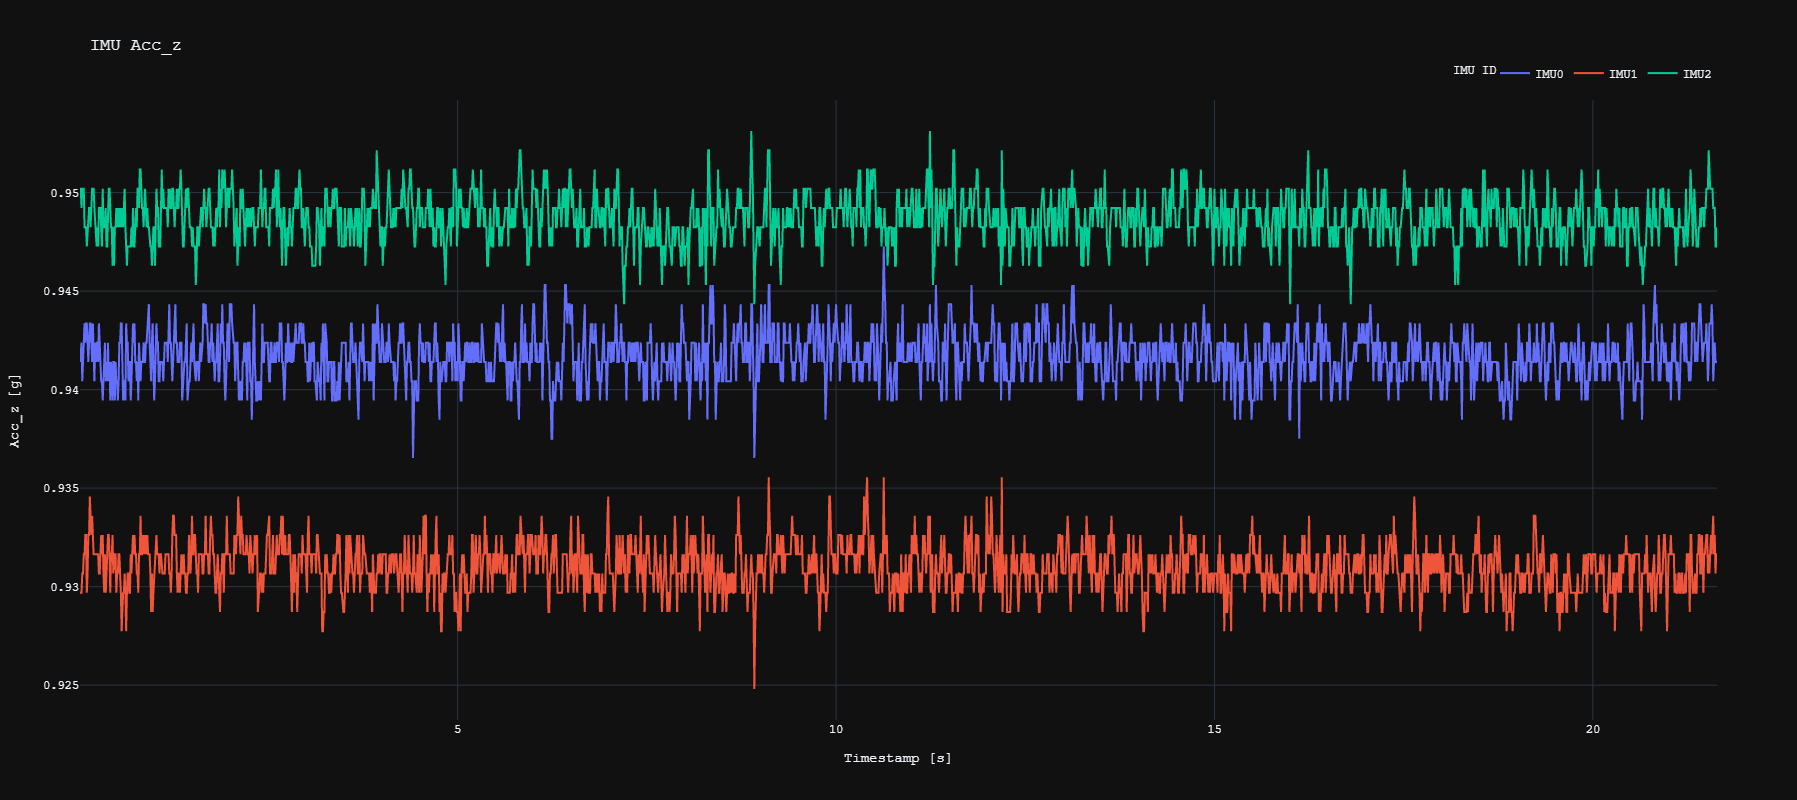

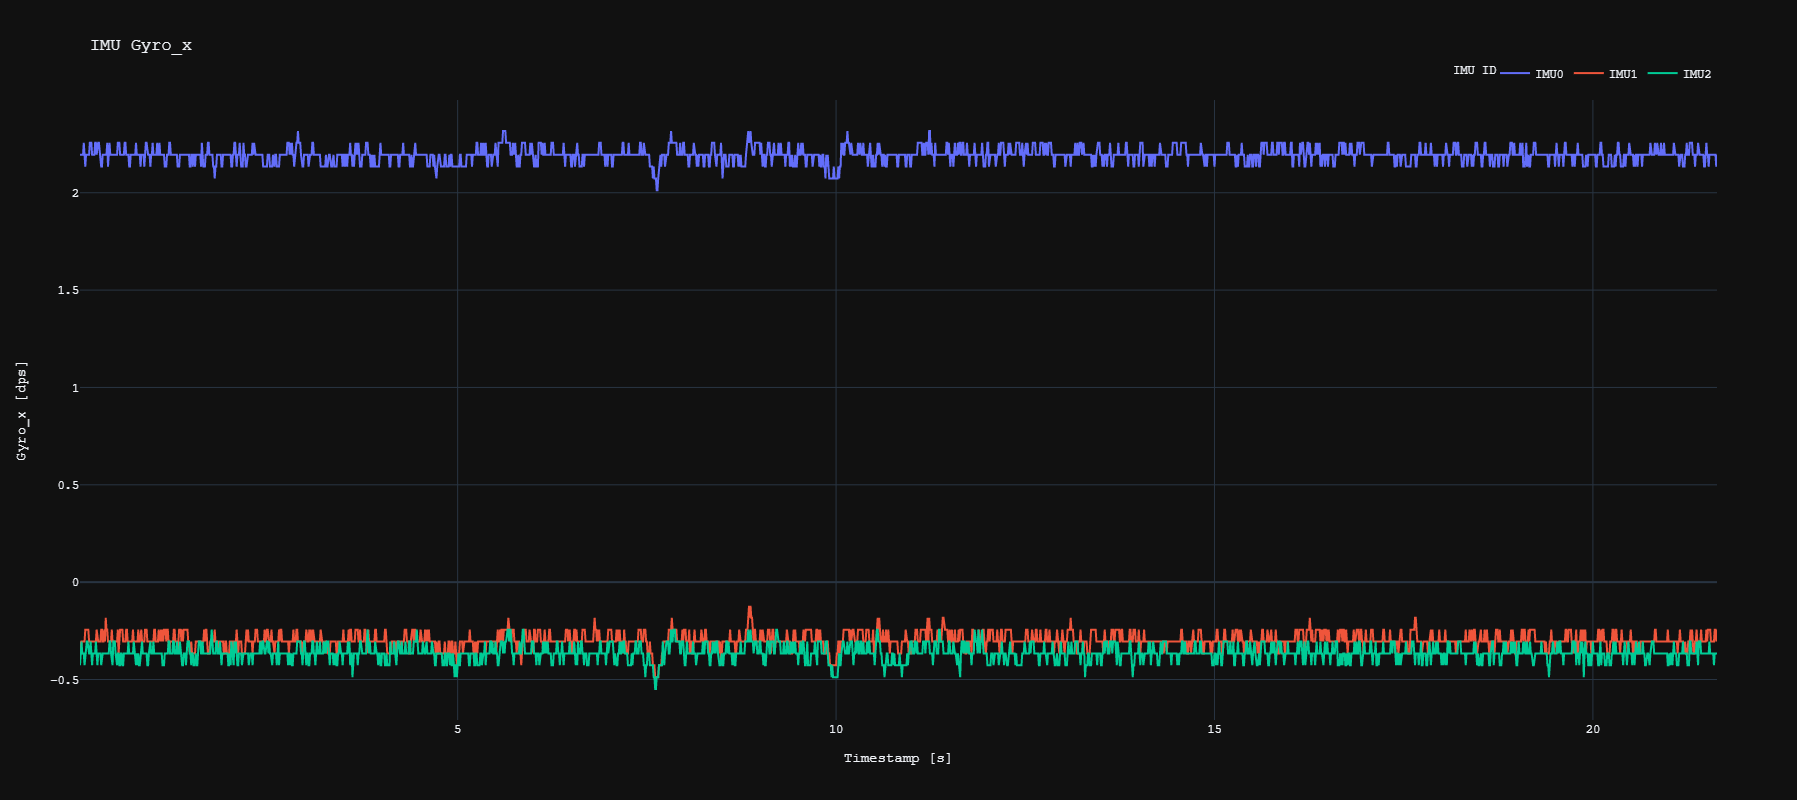

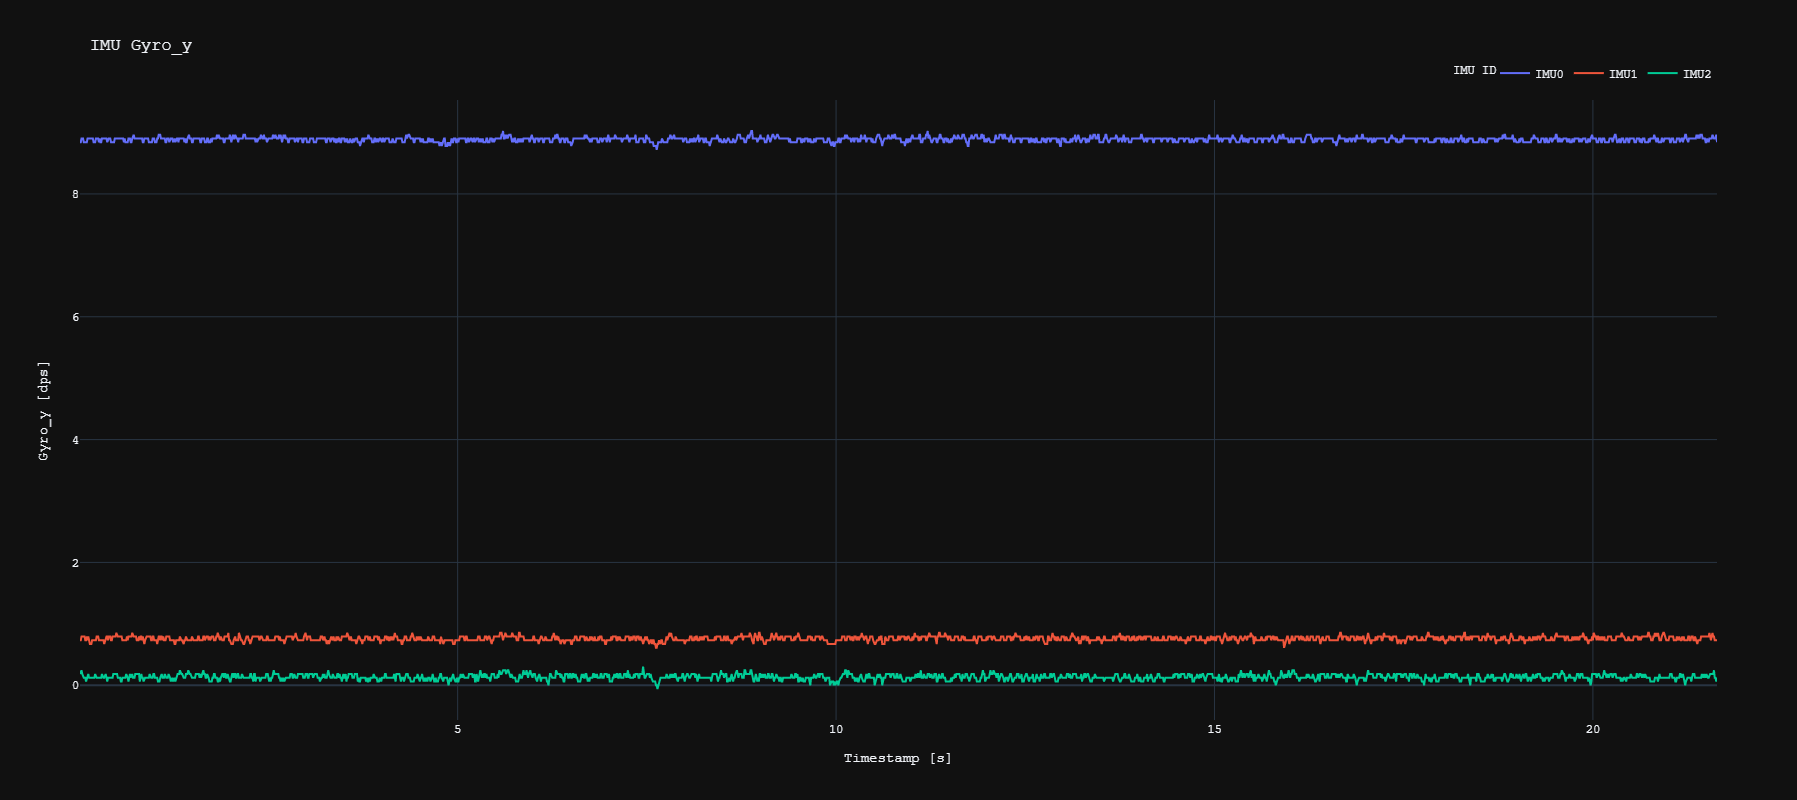

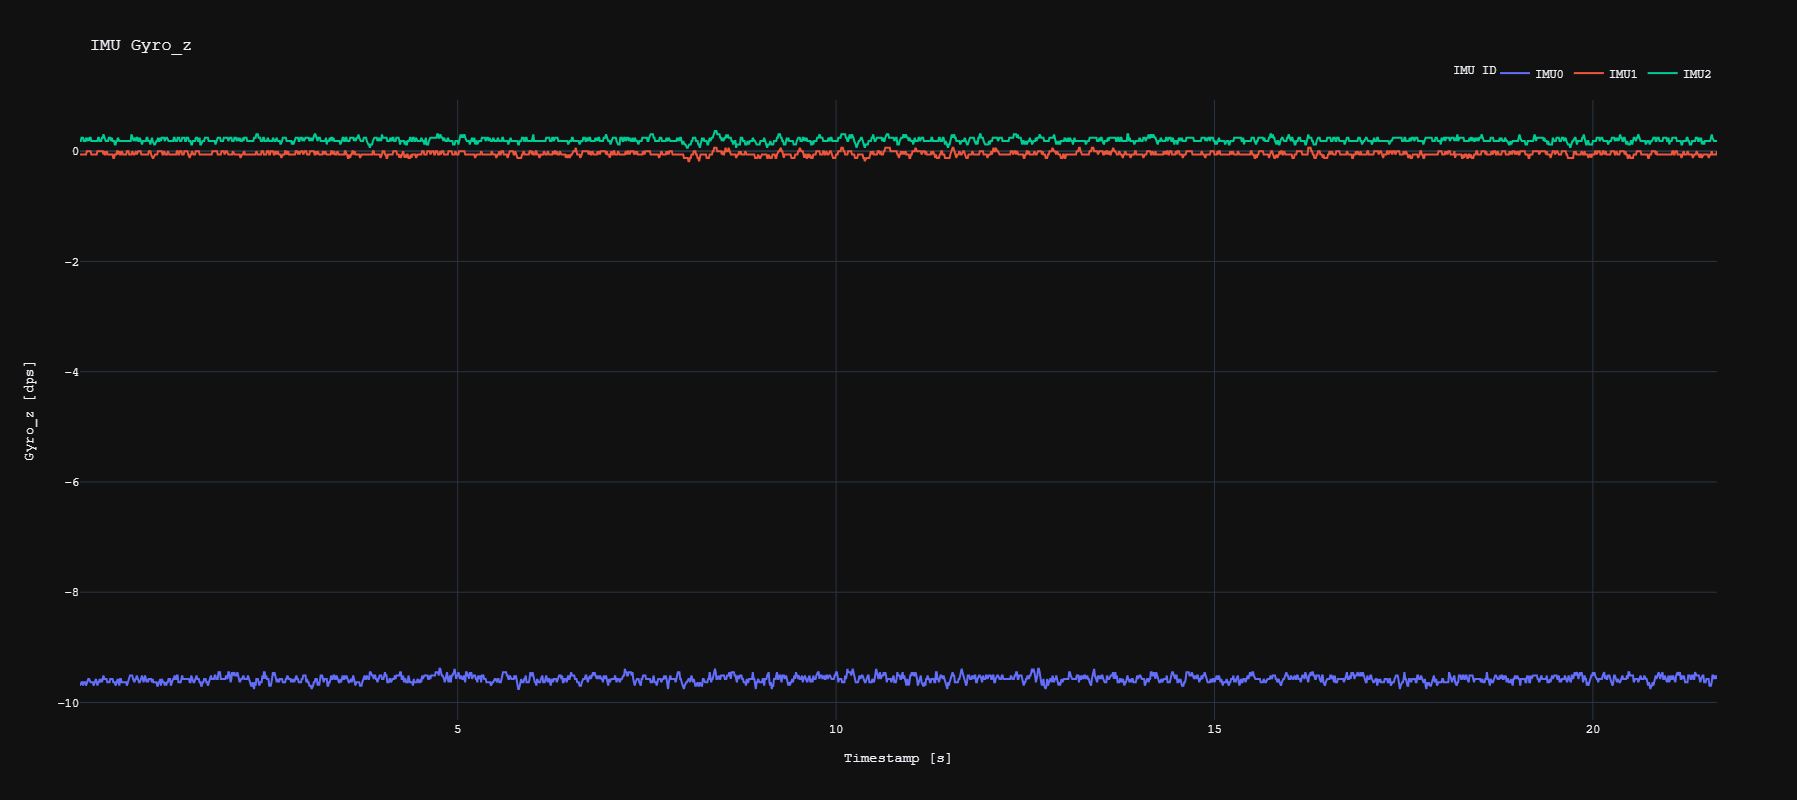

In [104]:
plot_imu_data(imu_df, flight_states_df, event_info_df)

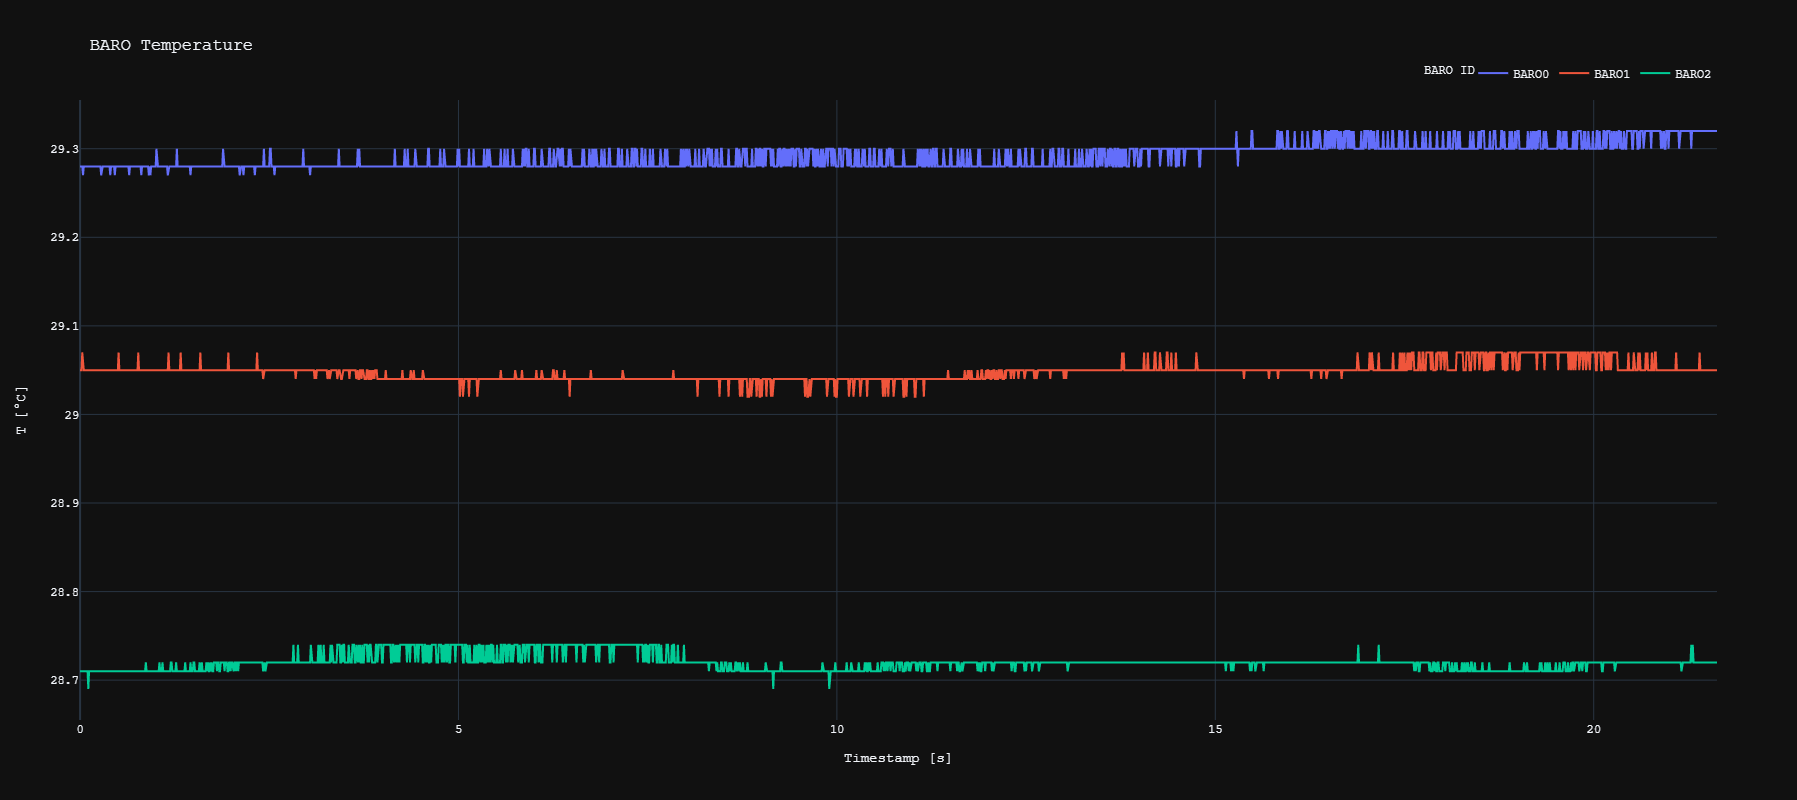

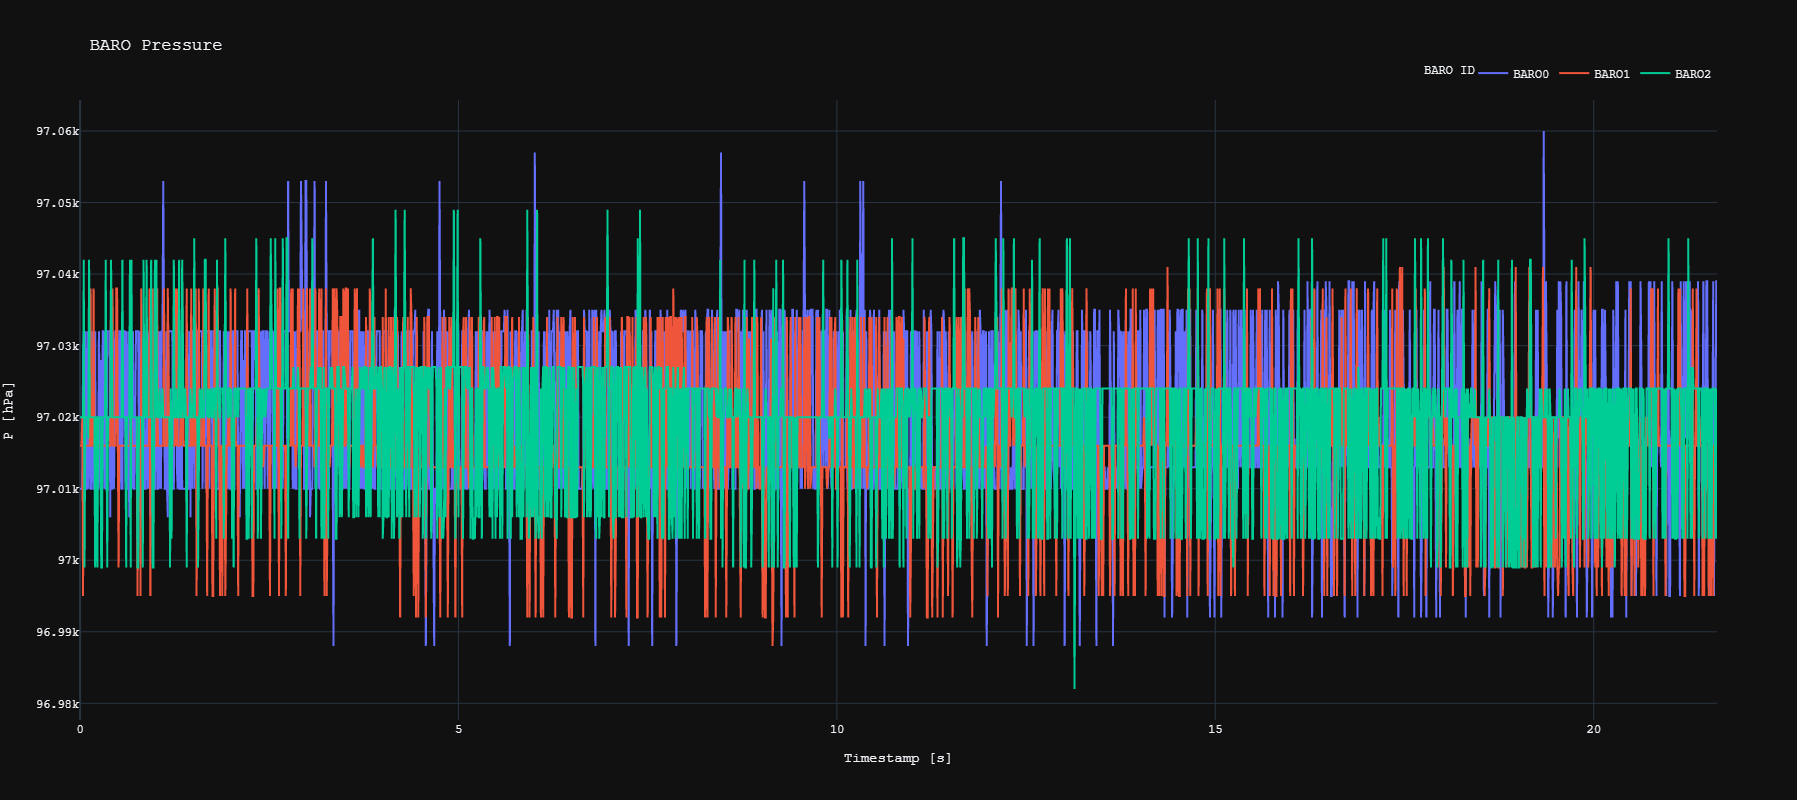

In [105]:
plot_baro_data(baro_df, flight_states_df, event_info_df)

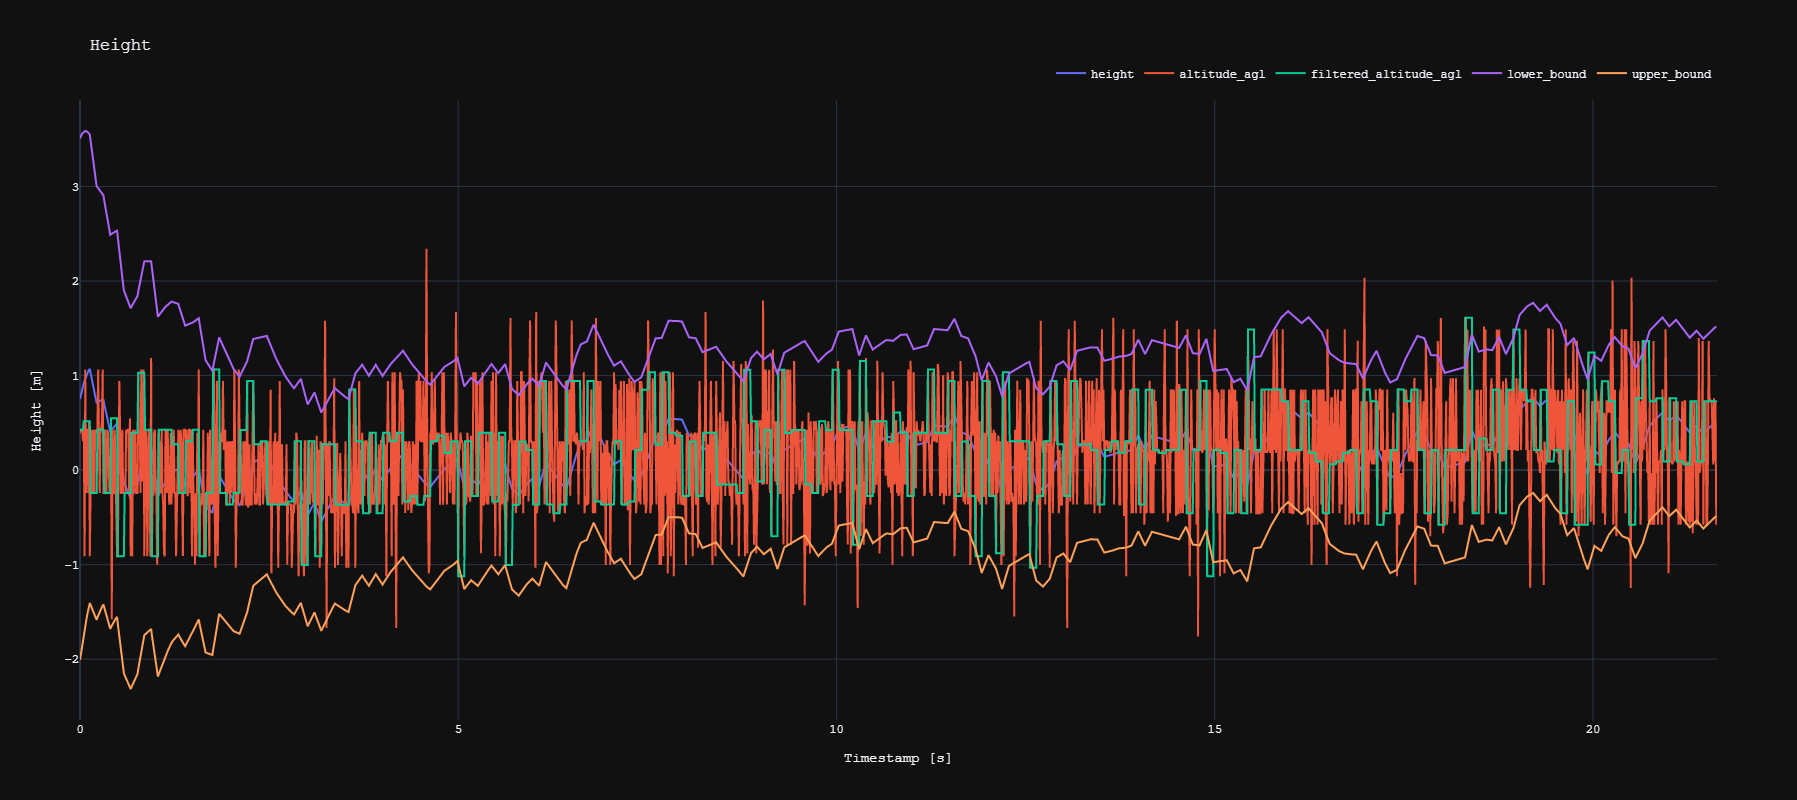

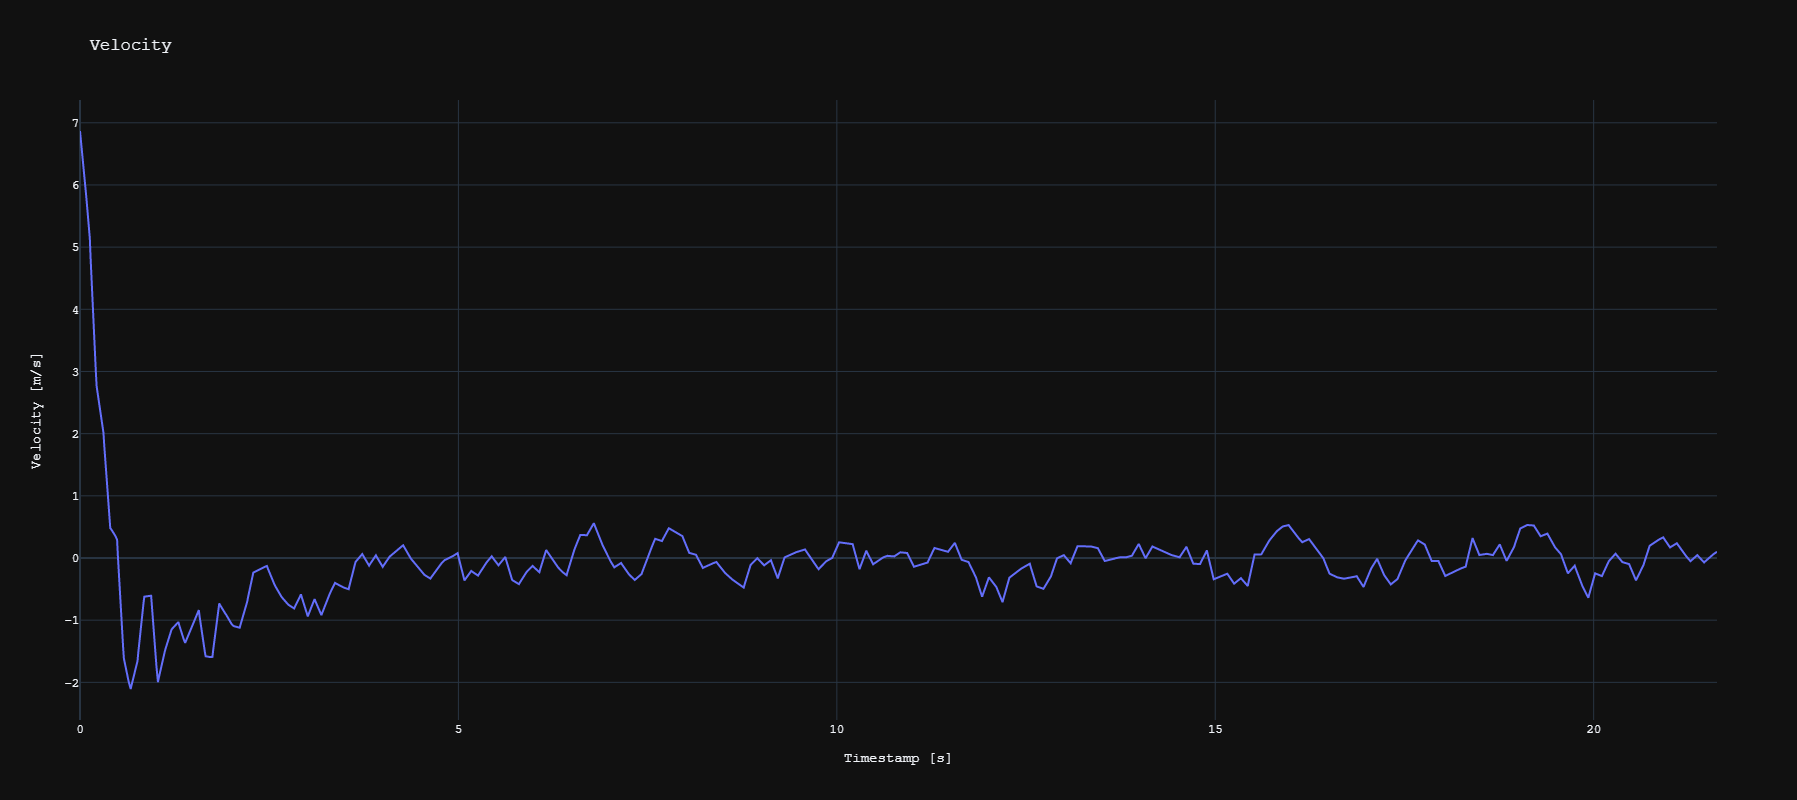

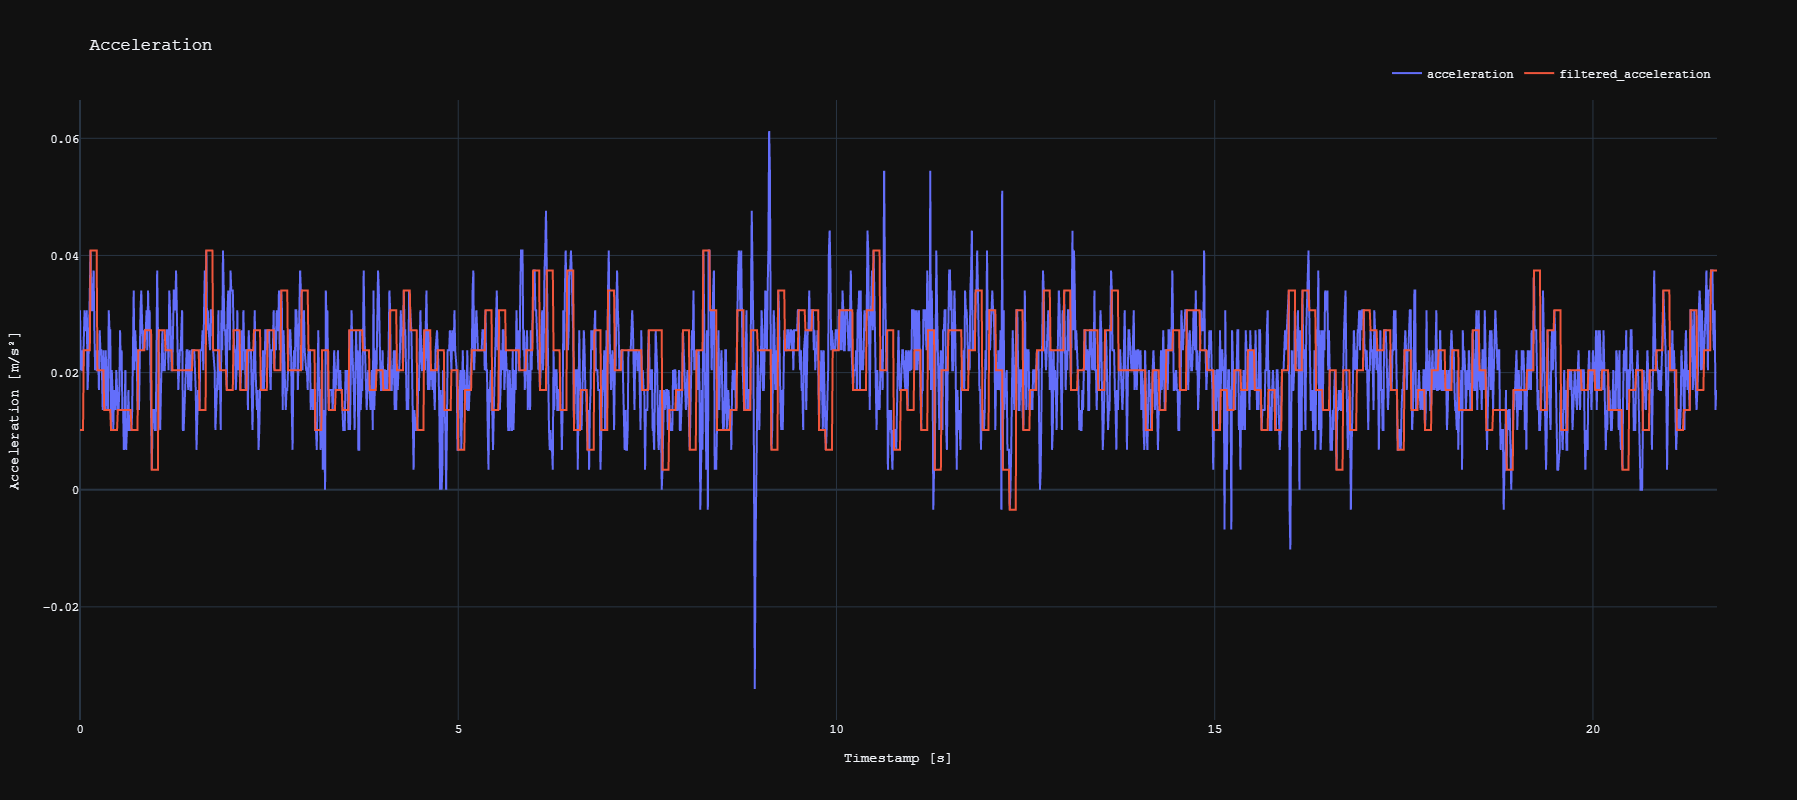

In [106]:
plot_flight_info(flight_info_df, filtered_data_info_df, flight_states_df, event_info_df)

In [86]:
sensor_info_df.max()

ts        21.64
imu_0      0.00
imu_1      0.00
imu_2      0.00
baro_0     0.00
baro_1     0.00
baro_2     0.00
dtype: float64